In [167]:
import os
import random
import numpy as np
import tensorflow as tf
import time

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers
from keras.layers import Embedding,Flatten

In [116]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # Number of images used in each iteration
    EPOCHS = 12  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 12


In [117]:
#################
# Configuration #
#################

# dictionary of languages that our classifier will cover
LANGUAGES_DICT = {'BEI':0,'MSA':1,'CAI':2,'DOH':3,'RAB':4,'TUN':5}
"""
LANGUAGES_DICT = {'ALE':0,'ALG':1,'ALX':2,'AMM':3,'ASW':4,'BAG':5,
                'BAS':6,'BEI':7,'BEN':8,'CAI':9,'DAM':10,'DOH':11,
                  'FES':12,'JED':13,'JER':14,'KHA':15,'MOS':16,'MSA':17,
                  'MUS':18,'RAB':19,'RIY':20,'SAL':21,'SAN':22,'SFX':23,
                  'TRI':24,'TUN':25}
"""

# Length of cleaned text used for training and prediction - 140 chars
MAX_LEN = 250

# number of language samples per language that we will extract from source files
NUM_SAMPLES = 9000
NUM_test = 1000

# For reproducibility
SEED = 42

import support #import define_alphabet
# Load the Alphabet
alphabet = support.define_alphabet()
print('ALPHABET:')
print(alphabet[1])

VOCAB_SIZE = len(alphabet[1])
print('ALPHABET LEN(VOCAB SIZE):', VOCAB_SIZE)

# Folders from where load / store the raw, source, cleaned, samples and train_test data
data_directory = "../data/Dialect6"
source_directory = os.path.join(data_directory, 'source')
cleaned_directory = os.path.join(data_directory, 'cleaned')
source_directory_test = os.path.join(data_directory, 'source_test')
cleaned_directory_test =os.path.join(data_directory, 'cleaned_test')
samples_directory = os.path.join('/tmp', 'samples')
train_test_directory = os.path.join('/tmp', 'train_test')

ALPHABET:
ءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىي ؟!?¿¡
ALPHABET LEN(VOCAB SIZE): 42


In [118]:
from support import get_sample_text, get_input_row
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained
path = os.path.join(cleaned_directory, "BEI_clean.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*MAX_LEN)
    sample_text = get_sample_text(content,random_index,MAX_LEN)
    print ("1. SAMPLE TEXT: \n", sample_text)
    print ("\n2. REFERENCE ALPHABET: \n", alphabet[0])
    
    sample_input_row = get_input_row(content, random_index, MAX_LEN, alphabet)
    print ("\n3. SAMPLE INPUT ROW: \n",sample_input_row)
    
    input_size = len(sample_input_row)
    if input_size != VOCAB_SIZE:
        print("Something strange happened!")
        
    print ("\n4. INPUT SIZE (VOCAB SIZE): ", input_size)
    del content

1. SAMPLE TEXT: 
 الضريبة
 تفضل الوصل بالشنطة
 شو بدك تشتري ؟
 ماري كانت عالوقت للتران بس جورج ما كان
 فيي حط هالرسالة فيه ؟
 بدي إشتري طعومة
 انا مش من هون
 فيك تفرجيني كيف بيتاكل هيدا ؟
 هالأوتيل عندو تجهيزات لمؤتمر ؟
 في شي حدا بيفهم ياباني ؟
 لسوء الحظ هوي كتير

2. REFERENCE ALPHABET: 
 ['ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', ' ', '؟', '!', '?', '¿', '¡']

3. SAMPLE INPUT ROW: 
 [1, 0, 1, 1, 1, 0, 21, 8, 4, 14, 0, 4, 3, 0, 5, 0, 10, 1, 3, 6, 1, 2, 3, 1, 3, 0, 8, 1, 7, 16, 8, 10, 8, 10, 0, 23, 48, 5, 0, 0, 0, 0]

4. INPUT SIZE (VOCAB SIZE):  42


In [151]:
# Utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((NUM_SAMPLES*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        print(content_length)
        remaining = content_length - MAX_LEN*NUM_SAMPLES
        jump = int(((remaining/NUM_SAMPLES)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_SAMPLES):
            if (content_length-start_index < 300):
                break
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            #print(idx,' ',start_index,' ',MAX_LEN)
            
            sample_data[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1
            #print(counter)
            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# Let's randomy shuffle the data
print(counter)
new_data = sample_data[:counter-1,]
np.random.shuffle(new_data)
print(set(new_data[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",new_data.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl,data=new_data)
print(path_smpl, "size : ", size_mb(os.path.getsize(path_smpl)))
del sample_data,new_data


Processing file : ../data/Dialect6/cleaned/BEI_clean.txt
267225
File size :  0.27 MB  | # possible samples :  6362 | # skip chars : -165
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/MSA_clean.txt
322546
File size :  0.32 MB  | # possible samples :  7679 | # skip chars : -160
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/CAI_clean.txt
288771
File size :  0.29 MB  | # possible samples :  6875 | # skip chars : -163
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/DOH_clean.txt
263868
File size :  0.26 MB  | # possible samples :  6282 | # skip chars : -165
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/RAB_c

In [152]:

sample_data_test = np.empty((NUM_test*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
#print(set(sample_data_test[:,-1]))
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file
counter = 0
for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory_test, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        remaining = content_length - MAX_LEN*NUM_test
        jump = int(((remaining/NUM_test)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_test):
            if (content_length-start_index < 300):
                break
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            #print(NUM_test*lang_seq+idx)
            sample_data_test[counter,] = input_row + [LANGUAGES_DICT[lang_code]]
            counter = counter +1

            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
print('idx',idx)
print('counter',counter)
print(len(sample_data_test[:counter,]))
new_data = sample_data_test[:counter-1,]
    
# Let's randomy shuffle the data
np.random.shuffle(new_data)
print(set(new_data[:,-1]))
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",sample_data_test[:counter,].shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl_test = os.path.join(samples_directory,"lang_samples_test_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl_test,data=new_data)
print(path_smpl_test, "size : ", size_mb(os.path.getsize(path_smpl_test)))
del sample_data_test,new_data

Processing file : ../data/Dialect6/cleaned_test/BEI_clean.txt
File size :  0.03 MB  | # possible samples :  701 | # skip chars : -165
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned_test/MSA_clean.txt
File size :  0.04 MB  | # possible samples :  845 | # skip chars : -160
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned_test/CAI_clean.txt
File size :  0.03 MB  | # possible samples :  761 | # skip chars : -163
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned_test/DOH_clean.txt
File size :  0.03 MB  | # possible samples :  689 | # skip chars : -165
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned_test/RAB_clean.tx

In [153]:
# utility function to turn language id into language code
def decode_langid(langid):    
    for dname, did in LANGUAGES_DICT.items():
        if did == langid:
            return dname

# Loading the data
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(VOCAB_SIZE)+".npz")
dt = np.load(path_smpl)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("\nSample language : ",decode_langid(dt[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt.shape)
bins = np.bincount(dt[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins[LANGUAGES_DICT[lang_code]])

Sample record : 
 [ 0  0  0  0  0  0 32  7  5 12  0  0  3  3 13  0 11  0  8  6  1  1  3  1
  5  1  1  4  2 21 14  9  6 13  0 13 46  2  0  0  0  0  2]

Sample language :  CAI

Dataset shape (Total_samples, Alphabet): (19823, 43)
Language bins count (samples per language): 
BEI 3141
MSA 3581
CAI 3316
DOH 3101
RAB 3474
TUN 3210


In [154]:


# Loading the data
path_smpl_test = os.path.join(samples_directory,"lang_samples_test_"+str(VOCAB_SIZE)+".npz")
dt_test = np.load(path_smpl_test)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt_test.shape[0])
print ("Sample record : \n",dt_test[random_index,])
print ("\nSample language : ",decode_langid(dt_test[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt_test.shape)
bins_test = np.bincount(dt_test[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins_test[LANGUAGES_DICT[lang_code]])

Sample record : 
 [ 0  0  2  0  2  0 22  5  8 14  2  1  3  6  4  0 12  1  2  6  3  0  3  0
  6  1  3  1  6  9 12 10  6 15  0 26 45  3  0  0  0  0  5]

Sample language :  TUN

Dataset shape (Total_samples, Alphabet): (2170, 43)
Language bins count (samples per language): 
BEI 343
MSA 392
CAI 365
DOH 337
RAB 381
TUN 352


In [155]:
# we need to preprocess data for DNN yet again - scale it 
# scaling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
dt = dt.astype(np.float32)
dt_test = dt_test.astype(np.float32)
# X and Y split
X_train = dt[:, 0:input_size] # Samples
Y_train = dt[:, input_size] # The last element is the label
print(set(Y_train))
X_test = dt_test[:, 0:input_size] # Samples
Y_test = dt_test[:, input_size] # The last element is the label
print(set(Y_test))
del dt,dt_test

# Random index to check random sample
random_index_train = random.randrange(0,X_train.shape[0])
print("Example data before processing:")
print("X : \n", X_train[random_index_train,])
print("Y : \n", Y_train[random_index_train])


# Random index to check random sample
random_index_test = random.randrange(0,X_test.shape[0])
print("Example data before processing:")
print("X : \n", X_test[random_index_test,])
print("Y : \n", Y_test[random_index_test])

# X PREPROCESSING
# Feature Standardization - Standar scaler will be useful later during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X = standard_scaler.transform(X_train)   
print ("X preprocessed shape :", X_train.shape)

standard_scaler = preprocessing.StandardScaler().fit(X_test)
X = standard_scaler.transform(X_test)   
print ("X preprocessed shape :", X_test.shape)


# Y PREPROCESSINGY 
# One-hot encoding
Y_train = keras.utils.to_categorical(Y_train, num_classes=len(LANGUAGES_DICT))
Y_test = keras.utils.to_categorical(Y_test, num_classes=len(LANGUAGES_DICT))


# See the sample data
print("\nExample data after processing:")
print("X : \n", X_train[random_index_train,])
print("Y : \n", Y_train[random_index_train])

print("\nExample  tets data after processing:")
print("X : \n", X_test[random_index_test,])
print("Y : \n", Y_test[random_index_test])

# Train/test split. Static seed to have comparable results for different runs
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)


# Create the train / test directory if not extists
if not os.path.exists(train_test_directory):
    os.makedirs(train_test_directory)

# Save compressed train_test data to disk
path_tt = os.path.join(train_test_directory,"train_test_data_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))


path_tt_test = os.path.join(train_test_directory,"train_test_data_test_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt_test,X_test=X_test,Y_test=Y_test)
print(path_tt_test, "size : ",size_mb(os.path.getsize(path_tt_test)))


del X_train,Y_train,X_test,Y_test


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
Example data before processing:
X : 
 [ 0.  0.  2.  0.  0.  0. 18. 11.  7. 13.  1.  6.  3.  3.  4.  1.  9.  0.
  8.  5.  1.  1.  2.  0. 13.  0.  7.  0. 11.  7.  9. 15.  0.  6.  1. 13.
 51.  7.  0.  0.  0.  0.]
Y : 
 5.0
Example data before processing:
X : 
 [ 1.  0.  2.  0.  1.  0. 18.  8.  5. 13.  0.  2.  5.  2. 10.  0.  8.  0.
  4.  6.  3.  0.  3.  1.  9.  1.  5.  1. 11. 14. 14. 11.  4. 11.  0. 19.
 46.  3.  0.  0.  0.  0.]
Y : 
 0.0
X preprocessed shape : (19823, 42)
X preprocessed shape : (2170, 42)

Example data after processing:
X : 
 [ 0.  0.  2.  0.  0.  0. 18. 11.  7. 13.  1.  6.  3.  3.  4.  1.  9.  0.
  8.  5.  1.  1.  2.  0. 13.  0.  7.  0. 11.  7.  9. 15.  0.  6.  1. 13.
 51.  7.  0.  0.  0.  0.]
Y : 
 [0. 0. 0. 0. 0. 1.]

Example  tets data after processing:
X : 
 [ 1.  0.  2.  0.  1.  0. 18.  8.  5. 13.  0.  2.  5.  2. 10.  0.  8.  0.
  4.  6.  3.  0.  3.  1.  9.  1.  5.  1. 11. 14. 14. 11.  4. 11.  0. 19.
 46

In [156]:

# Load train data first from file
path_tt = os.path.join(train_test_directory, "train_test_data_"+str(VOCAB_SIZE)+".npz")
train_test_data = np.load(path_tt)
# Load train data first from file
path_tt_test = os.path.join(train_test_directory, "train_test_data_test_"+str(VOCAB_SIZE)+".npz")
train_test_data_test = np.load(path_tt_test)

# Train Set
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)

# Test Set
X_test = train_test_data_test['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data_test['Y_test']
print ("Y_test: ",Y_test.shape)

del train_test_data

X_train:  (19823, 42)
Y_train:  (19823, 6)
X_test:  (2170, 42)
Y_test:  (2170, 6)


In [185]:

model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.
model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(LANGUAGES_DICT), kernel_initializer="glorot_uniform", activation="sigmoid"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 500)               21500     
_________________________________________________________________
dropout_17 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_18 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 606       
Total para

In [191]:
from keras.callbacks import TensorBoard

# Tensorboard
tensorboard = TensorBoard(log_dir="run")
from keras.callbacks import EarlyStopping,ModelCheckpoint
filepath="weights.best.madar6_1000min.hdf5"


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpoint]

# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
                  epochs=1000,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=callbacks_list,#[tensorboard],
                  shuffle=True#,
                  #verbose=2
                   )


model.save_weights(filepath) 

Train on 17840 samples, validate on 1983 samples
Epoch 1/1000
17840/17840 [==============================] - 2s 112us/step - loss: 0.0489 - acc: 0.9833 - val_loss: 0.3213 - val_acc: 0.9269

Epoch 00001: val_loss improved from inf to 0.32134, saving model to weights.best.madar6_1000min.hdf5
Epoch 2/1000
17840/17840 [==============================] - 2s 104us/step - loss: 0.0425 - acc: 0.9858 - val_loss: 0.3205 - val_acc: 0.9274

Epoch 00002: val_loss improved from 0.32134 to 0.32053, saving model to weights.best.madar6_1000min.hdf5
Epoch 3/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0551 - acc: 0.9825 - val_loss: 0.3252 - val_acc: 0.9259

Epoch 00003: val_loss did not improve from 0.32053
Epoch 4/1000
17840/17840 [==============================] - 2s 108us/step - loss: 0.0445 - acc: 0.9838 - val_loss: 0.3048 - val_acc: 0.9299

Epoch 00004: val_loss improved from 0.32053 to 0.30476, saving model to weights.best.madar6_1000min.hdf5
Epoch 5/1000
17840/17840 

17840/17840 [==============================] - 2s 102us/step - loss: 0.0393 - acc: 0.9866 - val_loss: 0.3238 - val_acc: 0.9239

Epoch 00042: val_loss did not improve from 0.29716
Epoch 43/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0425 - acc: 0.9857 - val_loss: 0.3241 - val_acc: 0.9284

Epoch 00043: val_loss did not improve from 0.29716
Epoch 44/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0388 - acc: 0.9855 - val_loss: 0.3396 - val_acc: 0.9279

Epoch 00044: val_loss did not improve from 0.29716
Epoch 45/1000
17840/17840 [==============================] - 2s 99us/step - loss: 0.0466 - acc: 0.9852 - val_loss: 0.3317 - val_acc: 0.9279

Epoch 00045: val_loss did not improve from 0.29716
Epoch 46/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0454 - acc: 0.9837 - val_loss: 0.3229 - val_acc: 0.9284

Epoch 00046: val_loss did not improve from 0.29716
Epoch 47/1000
17840/17840 [=======================


Epoch 00084: val_loss did not improve from 0.29716
Epoch 85/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0471 - acc: 0.9849 - val_loss: 0.3296 - val_acc: 0.9289

Epoch 00085: val_loss did not improve from 0.29716
Epoch 86/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0390 - acc: 0.9867 - val_loss: 0.3223 - val_acc: 0.9264

Epoch 00086: val_loss did not improve from 0.29716
Epoch 87/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0503 - acc: 0.9843 - val_loss: 0.3098 - val_acc: 0.9294

Epoch 00087: val_loss did not improve from 0.29716
Epoch 88/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0500 - acc: 0.9836 - val_loss: 0.3325 - val_acc: 0.9294

Epoch 00088: val_loss did not improve from 0.29716
Epoch 89/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0474 - acc: 0.9852 - val_loss: 0.3044 - val_acc: 0.9319

Epoch 00089: val_loss did not impr

17840/17840 [==============================] - 2s 108us/step - loss: 0.0460 - acc: 0.9850 - val_loss: 0.3207 - val_acc: 0.9269

Epoch 00127: val_loss did not improve from 0.29716
Epoch 128/1000
17840/17840 [==============================] - 2s 104us/step - loss: 0.0447 - acc: 0.9855 - val_loss: 0.3182 - val_acc: 0.9259

Epoch 00128: val_loss did not improve from 0.29716
Epoch 129/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0512 - acc: 0.9846 - val_loss: 0.3250 - val_acc: 0.9284

Epoch 00129: val_loss did not improve from 0.29716
Epoch 130/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0480 - acc: 0.9853 - val_loss: 0.3077 - val_acc: 0.9299

Epoch 00130: val_loss did not improve from 0.29716
Epoch 131/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0422 - acc: 0.9865 - val_loss: 0.3191 - val_acc: 0.9254

Epoch 00131: val_loss did not improve from 0.29716
Epoch 132/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 100us/step - loss: 0.0411 - acc: 0.9874 - val_loss: 0.3290 - val_acc: 0.9274

Epoch 00211: val_loss did not improve from 0.29459
Epoch 212/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0449 - acc: 0.9856 - val_loss: 0.3040 - val_acc: 0.9309

Epoch 00212: val_loss did not improve from 0.29459
Epoch 213/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0430 - acc: 0.9867 - val_loss: 0.3111 - val_acc: 0.9259

Epoch 00213: val_loss did not improve from 0.29459
Epoch 214/1000
17840/17840 [==============================] - 2s 105us/step - loss: 0.0363 - acc: 0.9876 - val_loss: 0.3296 - val_acc: 0.9289

Epoch 00214: val_loss did not improve from 0.29459
Epoch 215/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0387 - acc: 0.9876 - val_loss: 0.3340 - val_acc: 0.9274

Epoch 00215: val_loss did not improve from 0.29459
Epoch 216/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 101us/step - loss: 0.0380 - acc: 0.9864 - val_loss: 0.3222 - val_acc: 0.9264

Epoch 00295: val_loss did not improve from 0.29175
Epoch 296/1000
17840/17840 [==============================] - 2s 99us/step - loss: 0.0421 - acc: 0.9865 - val_loss: 0.3254 - val_acc: 0.9289

Epoch 00296: val_loss did not improve from 0.29175
Epoch 297/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0435 - acc: 0.9853 - val_loss: 0.3263 - val_acc: 0.9294

Epoch 00297: val_loss did not improve from 0.29175
Epoch 298/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0413 - acc: 0.9869 - val_loss: 0.3223 - val_acc: 0.9294

Epoch 00298: val_loss did not improve from 0.29175
Epoch 299/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0458 - acc: 0.9849 - val_loss: 0.3175 - val_acc: 0.9279

Epoch 00299: val_loss did not improve from 0.29175
Epoch 300/1000
17840/17840 [==================

17840/17840 [==============================] - 2s 101us/step - loss: 0.0379 - acc: 0.9881 - val_loss: 0.3241 - val_acc: 0.9259

Epoch 00379: val_loss did not improve from 0.29175
Epoch 380/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0366 - acc: 0.9881 - val_loss: 0.3286 - val_acc: 0.9244

Epoch 00380: val_loss did not improve from 0.29175
Epoch 381/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0395 - acc: 0.9869 - val_loss: 0.3156 - val_acc: 0.9314

Epoch 00381: val_loss did not improve from 0.29175
Epoch 382/1000
17840/17840 [==============================] - 2s 105us/step - loss: 0.0388 - acc: 0.9865 - val_loss: 0.3038 - val_acc: 0.9304

Epoch 00382: val_loss did not improve from 0.29175
Epoch 383/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0405 - acc: 0.9879 - val_loss: 0.3187 - val_acc: 0.9259

Epoch 00383: val_loss did not improve from 0.29175
Epoch 384/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 100us/step - loss: 0.0352 - acc: 0.9882 - val_loss: 0.3204 - val_acc: 0.9304

Epoch 00463: val_loss did not improve from 0.29054
Epoch 464/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0372 - acc: 0.9876 - val_loss: 0.3347 - val_acc: 0.9279

Epoch 00464: val_loss did not improve from 0.29054
Epoch 465/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0399 - acc: 0.9875 - val_loss: 0.2972 - val_acc: 0.9304

Epoch 00465: val_loss did not improve from 0.29054
Epoch 466/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0380 - acc: 0.9877 - val_loss: 0.3107 - val_acc: 0.9289

Epoch 00466: val_loss did not improve from 0.29054
Epoch 467/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0391 - acc: 0.9874 - val_loss: 0.3149 - val_acc: 0.9284

Epoch 00467: val_loss did not improve from 0.29054
Epoch 468/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 102us/step - loss: 0.0410 - acc: 0.9868 - val_loss: 0.3260 - val_acc: 0.9329

Epoch 00547: val_loss did not improve from 0.29054
Epoch 548/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0386 - acc: 0.9876 - val_loss: 0.3050 - val_acc: 0.9289

Epoch 00548: val_loss did not improve from 0.29054
Epoch 549/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0402 - acc: 0.9863 - val_loss: 0.3139 - val_acc: 0.9319

Epoch 00549: val_loss did not improve from 0.29054
Epoch 550/1000
17840/17840 [==============================] - 2s 106us/step - loss: 0.0400 - acc: 0.9876 - val_loss: 0.3147 - val_acc: 0.9269

Epoch 00550: val_loss did not improve from 0.29054
Epoch 551/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0408 - acc: 0.9874 - val_loss: 0.3144 - val_acc: 0.9309

Epoch 00551: val_loss did not improve from 0.29054
Epoch 552/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 101us/step - loss: 0.0367 - acc: 0.9884 - val_loss: 0.3128 - val_acc: 0.9309

Epoch 00631: val_loss did not improve from 0.29054
Epoch 632/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0410 - acc: 0.9881 - val_loss: 0.3237 - val_acc: 0.9259

Epoch 00632: val_loss did not improve from 0.29054
Epoch 633/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0394 - acc: 0.9871 - val_loss: 0.3134 - val_acc: 0.9284

Epoch 00633: val_loss did not improve from 0.29054
Epoch 634/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0376 - acc: 0.9877 - val_loss: 0.3413 - val_acc: 0.9299

Epoch 00634: val_loss did not improve from 0.29054
Epoch 635/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0447 - acc: 0.9853 - val_loss: 0.3066 - val_acc: 0.9319

Epoch 00635: val_loss did not improve from 0.29054
Epoch 636/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 103us/step - loss: 0.0319 - acc: 0.9900 - val_loss: 0.3248 - val_acc: 0.9274

Epoch 00715: val_loss did not improve from 0.29054
Epoch 716/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0371 - acc: 0.9881 - val_loss: 0.3196 - val_acc: 0.9304

Epoch 00716: val_loss did not improve from 0.29054
Epoch 717/1000
17840/17840 [==============================] - 2s 104us/step - loss: 0.0388 - acc: 0.9882 - val_loss: 0.3249 - val_acc: 0.9259

Epoch 00717: val_loss did not improve from 0.29054
Epoch 718/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0386 - acc: 0.9873 - val_loss: 0.3310 - val_acc: 0.9299

Epoch 00718: val_loss did not improve from 0.29054
Epoch 719/1000
17840/17840 [==============================] - 2s 100us/step - loss: 0.0335 - acc: 0.9896 - val_loss: 0.3247 - val_acc: 0.9299

Epoch 00719: val_loss did not improve from 0.29054
Epoch 720/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 104us/step - loss: 0.0348 - acc: 0.9885 - val_loss: 0.3310 - val_acc: 0.9274

Epoch 00799: val_loss did not improve from 0.29054
Epoch 800/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0422 - acc: 0.9877 - val_loss: 0.3373 - val_acc: 0.9269

Epoch 00800: val_loss did not improve from 0.29054
Epoch 801/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0316 - acc: 0.9886 - val_loss: 0.3294 - val_acc: 0.9289

Epoch 00801: val_loss did not improve from 0.29054
Epoch 802/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0359 - acc: 0.9884 - val_loss: 0.3175 - val_acc: 0.9309

Epoch 00802: val_loss did not improve from 0.29054
Epoch 803/1000
17840/17840 [==============================] - 2s 110us/step - loss: 0.0352 - acc: 0.9886 - val_loss: 0.3330 - val_acc: 0.9249

Epoch 00803: val_loss did not improve from 0.29054
Epoch 804/1000
17840/17840 [=================

17840/17840 [==============================] - 2s 101us/step - loss: 0.0334 - acc: 0.9888 - val_loss: 0.3147 - val_acc: 0.9279

Epoch 00883: val_loss did not improve from 0.29054
Epoch 884/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0357 - acc: 0.9892 - val_loss: 0.3118 - val_acc: 0.9324

Epoch 00884: val_loss did not improve from 0.29054
Epoch 885/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0379 - acc: 0.9874 - val_loss: 0.3355 - val_acc: 0.9239

Epoch 00885: val_loss did not improve from 0.29054
Epoch 886/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0385 - acc: 0.9884 - val_loss: 0.3260 - val_acc: 0.9279

Epoch 00886: val_loss did not improve from 0.29054
Epoch 887/1000
17840/17840 [==============================] - 2s 99us/step - loss: 0.0341 - acc: 0.9888 - val_loss: 0.3196 - val_acc: 0.9289

Epoch 00887: val_loss did not improve from 0.29054
Epoch 888/1000
17840/17840 [==================

17840/17840 [==============================] - 2s 102us/step - loss: 0.0344 - acc: 0.9886 - val_loss: 0.3401 - val_acc: 0.9249

Epoch 00967: val_loss did not improve from 0.29054
Epoch 968/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0353 - acc: 0.9886 - val_loss: 0.3275 - val_acc: 0.9264

Epoch 00968: val_loss did not improve from 0.29054
Epoch 969/1000
17840/17840 [==============================] - 2s 101us/step - loss: 0.0354 - acc: 0.9879 - val_loss: 0.3233 - val_acc: 0.9304

Epoch 00969: val_loss did not improve from 0.29054
Epoch 970/1000
17840/17840 [==============================] - 2s 102us/step - loss: 0.0469 - acc: 0.9862 - val_loss: 0.3199 - val_acc: 0.9294

Epoch 00970: val_loss did not improve from 0.29054
Epoch 971/1000
17840/17840 [==============================] - 2s 103us/step - loss: 0.0375 - acc: 0.9883 - val_loss: 0.3166 - val_acc: 0.9294

Epoch 00971: val_loss did not improve from 0.29054
Epoch 972/1000
17840/17840 [=================

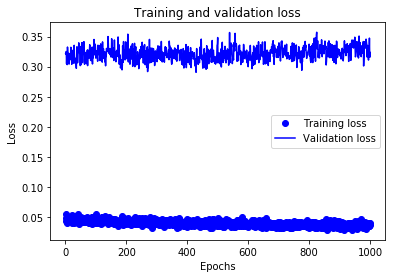

In [192]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



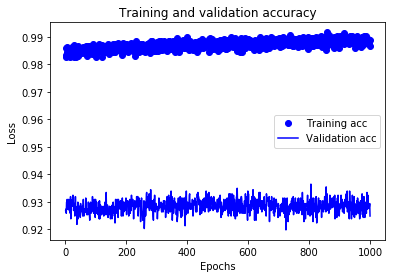

In [193]:
history_dict = history.history
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [194]:
model.load_weights(filepath)
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2170/2170 [==============================] - 0s 71us/step
acc: 91.15%


              precision    recall  f1-score   support

           0       0.89      0.95      0.92       343
           1       0.97      0.98      0.98       392
           2       0.87      0.86      0.87       365
           3       0.90      0.87      0.88       337
           4       0.94      0.93      0.94       381
           5       0.90      0.87      0.88       352

   micro avg       0.91      0.91      0.91      2170
   macro avg       0.91      0.91      0.91      2170
weighted avg       0.91      0.91      0.91      2170



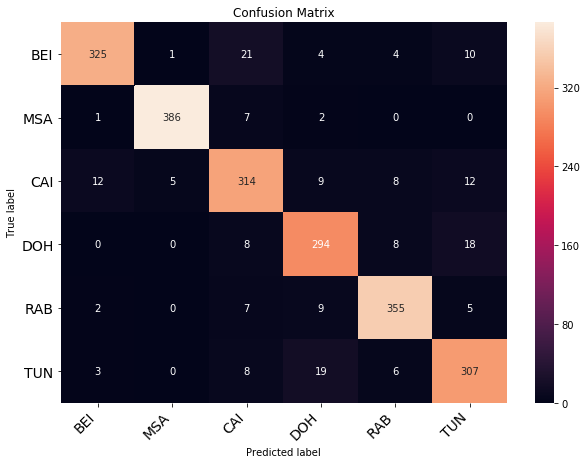

In [190]:
# and now we will prepare data for scikit-learn confusion matrix and classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(LANGUAGES_DICT))
LABELS =  list(LANGUAGES_DICT.keys())
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix,classification_report
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(Y_pred,axis=1), np.argmax(Y_test,axis=1))
_ = print_confusion_matrix(cnf_matrix, LABELS)
print(classification_report(np.argmax(Y_test,axis=1), np.argmax(Y_pred,axis=1)))


In [87]:
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import clean_text


def get_prediction(TEXT):
    if len(TEXT) < MAX_LEN:
        print("Text has to be at least {} chars long, but it is {}/{}".format(MAX_LEN, len(TEXT), MAX_LEN))
        return(-1)
    # Data cleaning
    print(" it is {}/{}".format(len(TEXT), MAX_LEN))
    cleaned_text = clean_text(TEXT)
    
    # Get the MAX_LEN char
    input_row = get_input_row(cleaned_text, 0, MAX_LEN, alphabet)
    
    # Data preprocessing (Standardization)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    
    # Prediction
    prediction = LABELS[model.predict_classes(test_array)[0]]
    print('TEXT:', TEXT, '\nPREDICTION:', prediction.upper(), '\nSCORE:', score)

interact_manual(get_prediction, TEXT=widgets.Textarea(placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'));

interactive(children=(Textarea(value='', description='TEXT', placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'…